In [1]:
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy.stats import ttest_1samp
import scikit_posthocs as sp
from typing import defaultdict
from scipy import stats
from cycler import cycle
from scipy.stats import ttest_ind, t
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
def extract_dicts(filepath):
    with open(filepath, "r") as f:
        text = f.read()
    
    dicts = []
    start = 0
    while True:
        start_idx = text.find("results_dict =", start)
        if start_idx == -1:
            break
        brace_idx = text.find("{", start_idx)
        if brace_idx == -1:
            break

        brace_count = 0
        end_idx = brace_idx
        while end_idx < len(text):
            if text[end_idx] == "{":
                brace_count += 1
            elif text[end_idx] == "}":
                brace_count -= 1
                if brace_count == 0:
                    break
            end_idx += 1
        
        dict_text = text[brace_idx:end_idx+1]
        parsed_dict = ast.literal_eval(dict_text)
        dicts.append(parsed_dict)
        start = end_idx + 1

    return dicts

# Read all markdown files
results = []

for filepath in Path("moleculeace_results").glob("*.md"):
    model_name = os.path.splitext(os.path.basename(filepath))[0]
    dicts = extract_dicts(filepath)
    for d in dicts:
        for benchmark, subtasks in d.items():
            for subtask, score in subtasks.items():
                results.append({
                    "model": model_name,
                    "benchmark": benchmark,
                    "subtask": subtask,
                    "score": score
                })

# Create DataFrame
df = pd.DataFrame(results)

df


,model,benchmark,subtask,score
0,MoLFormer,CHEMBL1862_Ki,cliff,0.798471
1,MoLFormer,CHEMBL1862_Ki,noncliff,0.784344
2,MoLFormer,CHEMBL1871_Ki,cliff,0.960874
3,MoLFormer,CHEMBL1871_Ki,noncliff,0.655728
4,MoLFormer,CHEMBL2034_Ki,cliff,0.954036
...,...,...,...,...
2035,RF_Morgan,CHEMBL4203_Ki,noncliff,0.832337
2036,RF_Morgan,CHEMBL4616_EC50,cliff,0.790373
2037,RF_Morgan,CHEMBL4616_EC50,noncliff,0.599416
2038,RF_Morgan,CHEMBL4792_Ki,cliff,0.720185


In [3]:
size_dict = {}
for benchmark_name in df["benchmark"].unique():
    bench_df = pd.read_csv(f"https://raw.githubusercontent.com/molML/MoleculeACE/7e6de0bd2968c56589c580f2a397f01c531ede26/MoleculeACE/Data/benchmark_data/{benchmark_name}.csv")
    test_df = bench_df[bench_df["split"] == "test"]
    size_dict[benchmark_name] = dict(
        cliff=len(test_df[test_df["cliff_mol"] == 1]),
        noncliff=len(test_df[test_df["cliff_mol"] == 0]),
    )

In [4]:
df["n_mols"] = df.apply(lambda row: size_dict[row['benchmark']][row['subtask']], axis=1)

In [5]:
df["benchmark"] = df["benchmark"].map(lambda s: s.split("_")[0].replace("CHEMBL", ""))

In [6]:
df

,model,benchmark,subtask,score,n_mols
0,MoLFormer,1862,cliff,0.798471,67
1,MoLFormer,1862,noncliff,0.784344,94
2,MoLFormer,1871,cliff,0.960874,32
3,MoLFormer,1871,noncliff,0.655728,102
4,MoLFormer,2034,cliff,0.954036,52
...,...,...,...,...,...
2035,RF_Morgan,4203,noncliff,0.832337,136
2036,RF_Morgan,4616,cliff,0.790373,73
2037,RF_Morgan,4616,noncliff,0.599416,66
2038,RF_Morgan,4792,cliff,0.720185,160


Number of nonsignificant differences per model:
model
CheMeleon             3
ChemProp              8
MLP_PLR_Pretrained    3
MoLFormer             5
RF_Morgan             1
fastprop              5
minimol               6
Name: same, dtype: int64
Rate (%) of nonsignificant differences per model:
model
CheMeleon             10.3
ChemProp              27.6
MLP_PLR_Pretrained    10.3
MoLFormer             17.2
RF_Morgan              3.4
fastprop              17.2
minimol               20.7
Name: same, dtype: float64


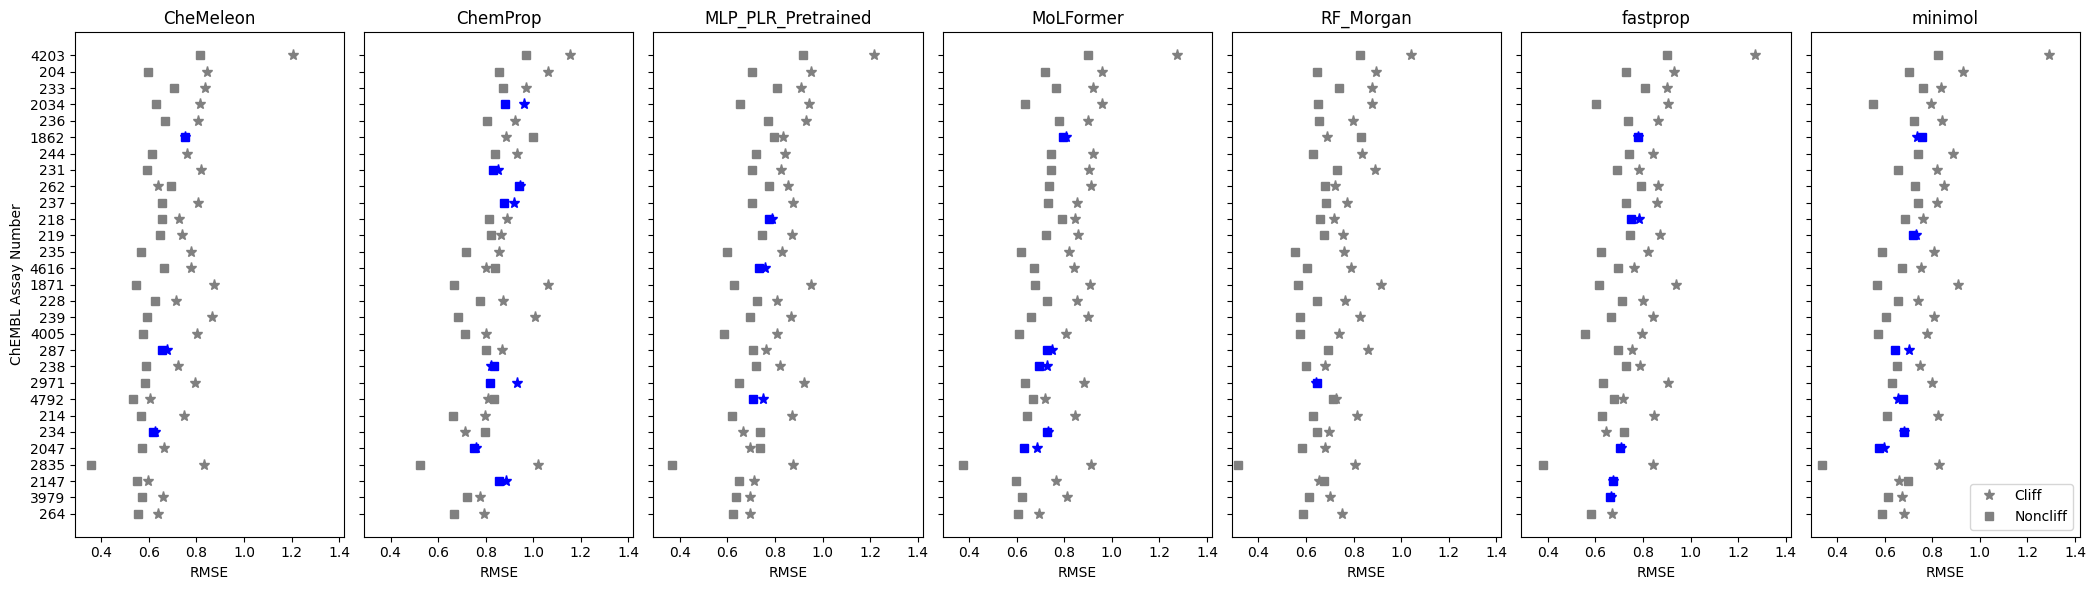

In [7]:
order = (df.groupby("benchmark")["score"]
           .median()
           .sort_values(ascending=True)
           .index)

pvals = []
results = []
alpha = 0.05
min_rmse = df["score"].min()*0.95
max_rmse = df["score"].max()*1.05
for (model, benchmark), group in df.groupby(['model', 'benchmark']):
    cliff_scores = group[group['subtask'] == 'cliff']['score']
    noncliff_scores = group[group['subtask'] == 'noncliff']['score']
    ttest_result = ttest_ind(cliff_scores, noncliff_scores, equal_var=False)
    pvals.append((model, benchmark, ttest_result.pvalue > alpha))
    cliff_mean = cliff_scores.mean()
    noncliff_mean = noncliff_scores.mean()
    results.append(
        {
            'model': model,
            'benchmark': benchmark,
            'cliff': cliff_mean,
            'noncliff': noncliff_mean,
        }
    )

pvals = pd.DataFrame(pvals, columns=['model', 'benchmark', 'same'])
nonsignificant = pvals.groupby('model')['same'].sum()

print("Number of nonsignificant differences per model:")
print(nonsignificant)

print("Rate (%) of nonsignificant differences per model:")
print((nonsignificant / len(df["benchmark"].unique()) * 100).round(1))

res_df = pd.DataFrame(results)
res_df = res_df.merge(pvals, on=['model', 'benchmark'])
res_df = res_df.set_index("benchmark")

fig, axes = plt.subplots(1, res_df['model'].nunique(), figsize=(3 * res_df['model'].nunique(), 6), sharex=True, sharey=True)

for ax, (model, data) in zip(axes, res_df.groupby('model')):
    for benchmark, row in data.loc[order].iterrows():
        color = 'blue' if row['same'] else 'grey'
        ax.errorbar(row['cliff'], benchmark, fmt='*', markersize=8, color=color, markeredgecolor=color)
        ax.errorbar(row['noncliff'], benchmark, fmt='s', markersize=6, color=color, markeredgecolor=color)
    ax.set_title(model)
    ax.set_xlim(min_rmse, max_rmse)
    ax.set_xlabel('RMSE')
    ax.set_yticks([])
ax = axes[0]
ax.set_yticks(range(len(df["benchmark"].unique())))
ax.set_ylabel('ChEMBL Assay Number')
ax = axes[-1]
ax.legend(['Cliff', 'Noncliff'], loc='lower right')

plt.tight_layout()
plt.show()


In [8]:
# iterate over pairs of the df to calculate the differences
records = []
for i, (model, model_df) in enumerate(df.groupby("model", sort=False)):
    for j, (benchmark, bench_df) in enumerate(model_df.groupby("benchmark", sort=False)):
        for k in range(0, len(bench_df), 2):
            records.append(
                dict(
                    model=model,
                    benchmark=benchmark,
                    diff=bench_df["score"].iloc[k] - bench_df["score"].iloc[k+1],
                    avg=(bench_df["n_mols"].iloc[k] * bench_df["score"].iloc[k] + bench_df["n_mols"].iloc[k + 1] * bench_df["score"].iloc[k+1]) / (bench_df["n_mols"].iloc[k] + bench_df["n_mols"].iloc[k + 1]),
                )
            )
df_2 = pd.DataFrame.from_dict(records)

In [9]:
df_2

,model,benchmark,diff,avg
0,MoLFormer,1862,0.014126,0.790223
1,MoLFormer,1862,-0.000925,0.807458
2,MoLFormer,1862,0.017897,0.815204
3,MoLFormer,1862,0.040132,0.804339
4,MoLFormer,1862,-0.018042,0.784705
...,...,...,...,...
1015,RF_Morgan,4792,0.013867,0.715106
1016,RF_Morgan,4792,0.017588,0.718422
1017,RF_Morgan,4792,0.011259,0.718142
1018,RF_Morgan,4792,0.018138,0.722039


In [10]:
# todo: run a tukey HSD on each benchmark across all models and make a dict mapping benchmark -> list[models] who are the statistical winners
winner_dict = {}
for benchmark, bench_df in df_2.groupby("benchmark", sort=False):
    tukey = pairwise_tukeyhsd(bench_df["avg"], bench_df["model"])
    best_model = bench_df.groupby("model")["avg"].mean().idxmin()
    winner_dict[benchmark] = set([best_model])
    for model_name in bench_df["model"].unique():
        if model_name == best_model:
            continue
        else:
            tukey_df = pd.DataFrame(tukey.summary()[1:], columns=[str(i) for i in tukey.summary()[0]])
            tukey_df["group1"] = tukey_df["group1"].map(str)
            tukey_df["group2"] = tukey_df["group2"].map(str)
            if tukey_df[
                ((tukey_df["group1"] == best_model) & (tukey_df["group2"] == model_name)) | 
                ((tukey_df["group1"] == model_name) & (tukey_df["group2"] == best_model))
            ]["reject"].values[0].data == False:
                winner_dict[benchmark].add(model_name)
                continue  # no need to check the rest
# the fade out statistical losers on the difference plot and somehow indicate what the actual winning RMSE was (maybe?)

In [11]:
winner_dict

{'1862': {'CheMeleon', 'MoLFormer', 'RF_Morgan', 'fastprop', 'minimol'},
 '1871': {'CheMeleon', 'RF_Morgan', 'minimol'},
 '2034': {'minimol'},
 '2047': {'CheMeleon', 'RF_Morgan', 'minimol'},
 '204': {'CheMeleon'},
 '2147': {'CheMeleon'},
 '214': {'CheMeleon'},
 '218': {'CheMeleon', 'RF_Morgan', 'minimol'},
 '219': {'CheMeleon', 'RF_Morgan'},
 '228': {'CheMeleon', 'RF_Morgan', 'minimol'},
 '231': {'CheMeleon'},
 '233': {'CheMeleon'},
 '234': {'CheMeleon'},
 '235': {'CheMeleon', 'RF_Morgan'},
 '236': {'CheMeleon', 'RF_Morgan'},
 '237': {'CheMeleon',
  'MLP_PLR_Pretrained',
  'MoLFormer',
  'RF_Morgan',
  'fastprop',
  'minimol'},
 '238': {'CheMeleon', 'RF_Morgan'},
 '239': {'CheMeleon', 'RF_Morgan', 'minimol'},
 '244': {'CheMeleon', 'RF_Morgan'},
 '262': {'CheMeleon', 'RF_Morgan'},
 '264': {'CheMeleon'},
 '2835': {'CheMeleon',
  'MLP_PLR_Pretrained',
  'RF_Morgan',
  'fastprop',
  'minimol'},
 '287': {'CheMeleon', 'minimol'},
 '2971': {'CheMeleon',
  'MLP_PLR_Pretrained',
  'MoLFormer',


In [12]:
win_tracker = defaultdict(int)

n_benchmarks = len(df_2["benchmark"].unique())
alpha = 0.05
xerr_dict = {}
for i, (model, model_df) in enumerate(df_2.groupby("model", sort=False)):
    xerr_dict[model] = {}
    for j, (benchmark, bench_df) in enumerate(model_df.groupby("benchmark", sort=False)):
        result = ttest_1samp(bench_df["diff"], 0.0, alternative="greater")
        xerr_dict[model][benchmark] = abs(result.confidence_interval(1 - alpha).low - bench_df["diff"].mean())
        if result.pvalue < alpha:
            ...  # mean is practically less than zero
        else:
            win_tracker[model] += 1

results = pd.DataFrame.from_records(
    [{
        "Model": model.replace("_", " "),
        "Consistent Count": win_count,
        "Consistency Rate (%)": 100 * win_count / n_benchmarks,
    } for model, win_count in win_tracker.items()
    ], index="Model").sort_values(by="Consistency Rate (%)", axis=0, ascending=False)
results.round(1)



,Consistent Count,Consistency Rate (%)
Model,,
ChemProp,9,31.0
fastprop,6,20.7
minimol,6,20.7
MLP PLR Pretrained,5,17.2
CheMeleon,4,13.8
MoLFormer,3,10.3
RF Morgan,3,10.3


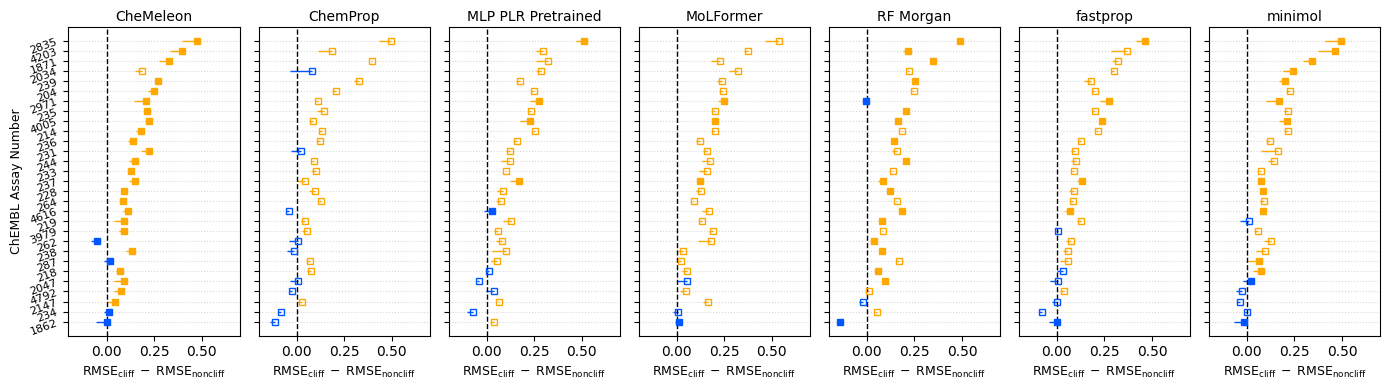

In [21]:
order = (df_2.groupby("benchmark")["diff"]
           .median()
           .sort_values(ascending=True)
           .index)
y_pos = np.arange(len(order))

models  = sorted(df_2["model"].unique())
n_models = len(models)
fig, axes = plt.subplots(1, n_models,
                         figsize=(2*n_models, 4),
                         sharey=True)
min_diff = min(-0.2, df_2["diff"].min()*1.1)
max_diff = df_2["diff"].max()*1.1
for i, (ax, mod) in enumerate(zip(axes, models)):
    sub = df_2[df_2["model"] == mod]
    means = sub.groupby("benchmark")["diff"].mean()[order]
    avg_errors = sub.groupby("benchmark")["avg"].mean()[order]
    is_consistent = []
    for j in range(means.shape[0]):
        bmark = means.index[j]
        color = "#0056FF" if (means[bmark] - xerr_dict[mod][bmark]) <= 0.0 else "#FFA900"
        alpha = 1.0 if mod in winner_dict[bmark] else 0.1
        ax.errorbar(means[bmark], y_pos[j],
                    xerr=(np.array([xerr_dict[mod][bmark]]), np.array([0])),
                    markersize=4, capsize=0, lw=1, marker='s', markerfacecolor='none' if (mod not in winner_dict[bmark]) else None,
                    color=(color, 1.0),
        )
        is_consistent.append(1 if means[bmark] - xerr_dict[mod][bmark] < 0 else 0)
    
    ax.axvline(0, color="k", lw=1, linestyle='--')
    ax.set_title(mod.replace("_", " "), fontsize=10, pad=4)
    ax.set_xlabel(r"$\mathrm{RMSE_{cliff}\;-\;RMSE_{noncliff}}$", fontsize=9, color="k")
    ax.spines['bottom'].set_color("k")
    ax.set_xlim(min_diff, max_diff)
    ax.tick_params(axis='x', which='both',
               color="k",
               labelcolor="k")
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    
    if i == 0:
        ax.set_yticks(y_pos)
        ax.set_yticklabels(order.to_list(), rotation=20, fontsize=8)
        ax.set_ylabel("ChEMBL Assay Number", fontsize=9)

plt.tight_layout(w_pad=1)
plt.savefig(Path("cliffs/mace_all.png"), dpi=600)
plt.show()

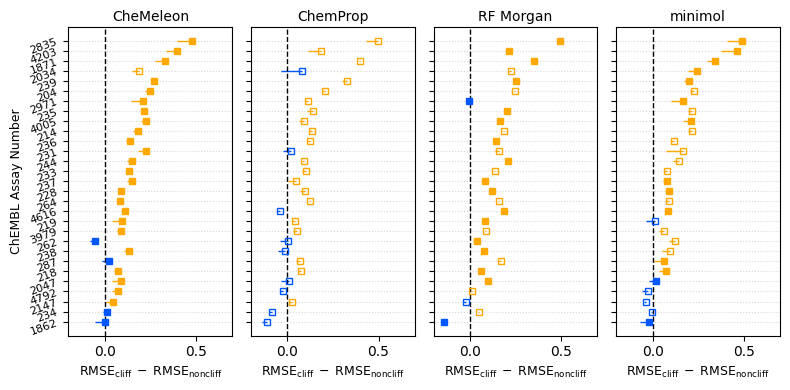

In [20]:
order = (df_2.groupby("benchmark")["diff"]
           .median()
           .sort_values(ascending=True)
           .index)
y_pos = np.arange(len(order))

models  = ["CheMeleon", "ChemProp", "RF_Morgan", "minimol"]
n_models = len(models)
fig, axes = plt.subplots(1, n_models,
                         figsize=(2*n_models, 4),
                         sharey=True)
min_diff = min(-0.2, df_2["diff"].min()*1.1)
max_diff = df_2["diff"].max()*1.1
for i, (ax, mod) in enumerate(zip(axes, models)):
    sub = df_2[df_2["model"] == mod]
    means = sub.groupby("benchmark")["diff"].mean()[order]
    avg_errors = sub.groupby("benchmark")["avg"].mean()[order]
    is_consistent = []
    for j in range(means.shape[0]):
        bmark = means.index[j]
        color = "#0056FF" if (means[bmark] - xerr_dict[mod][bmark]) <= 0.0 else "#FFA900"
        alpha = 1.0 if mod in winner_dict[bmark] else 0.1
        ax.errorbar(means[bmark], y_pos[j],
                    xerr=(np.array([xerr_dict[mod][bmark]]), np.array([0])),
                    markersize=4, capsize=0, lw=1, marker='s', markerfacecolor='none' if (mod not in winner_dict[bmark]) else None,
                    color=(color, 1.0),
        )
        is_consistent.append(1 if means[bmark] - xerr_dict[mod][bmark] < 0 else 0)
    
    ax.axvline(0, color="k", lw=1, linestyle='--')
    ax.set_title(mod.replace("_", " "), fontsize=10, pad=4)
    ax.set_xlabel(r"$\mathrm{RMSE_{cliff}\;-\;RMSE_{noncliff}}$", fontsize=9, color="k")
    ax.spines['bottom'].set_color("k")
    ax.set_xlim(min_diff, max_diff)
    ax.tick_params(axis='x', which='both',
               color="k",
               labelcolor="k")
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    
    if i == 0:
        ax.set_yticks(y_pos)
        ax.set_yticklabels(order.to_list(), rotation=20, fontsize=8)
        ax.set_ylabel("ChEMBL Assay Number", fontsize=9)

plt.tight_layout(w_pad=1)
plt.savefig(Path("cliffs/mace_subset.png"), dpi=600)
plt.show()

,model,win count,win rate (%)
2,CheMeleon,28,96.6
4,RF Morgan,18,62.1
0,minimol,14,48.3
3,fastprop,6,20.7
5,MLP PLR Pretrained,5,17.2
1,MoLFormer,4,13.8


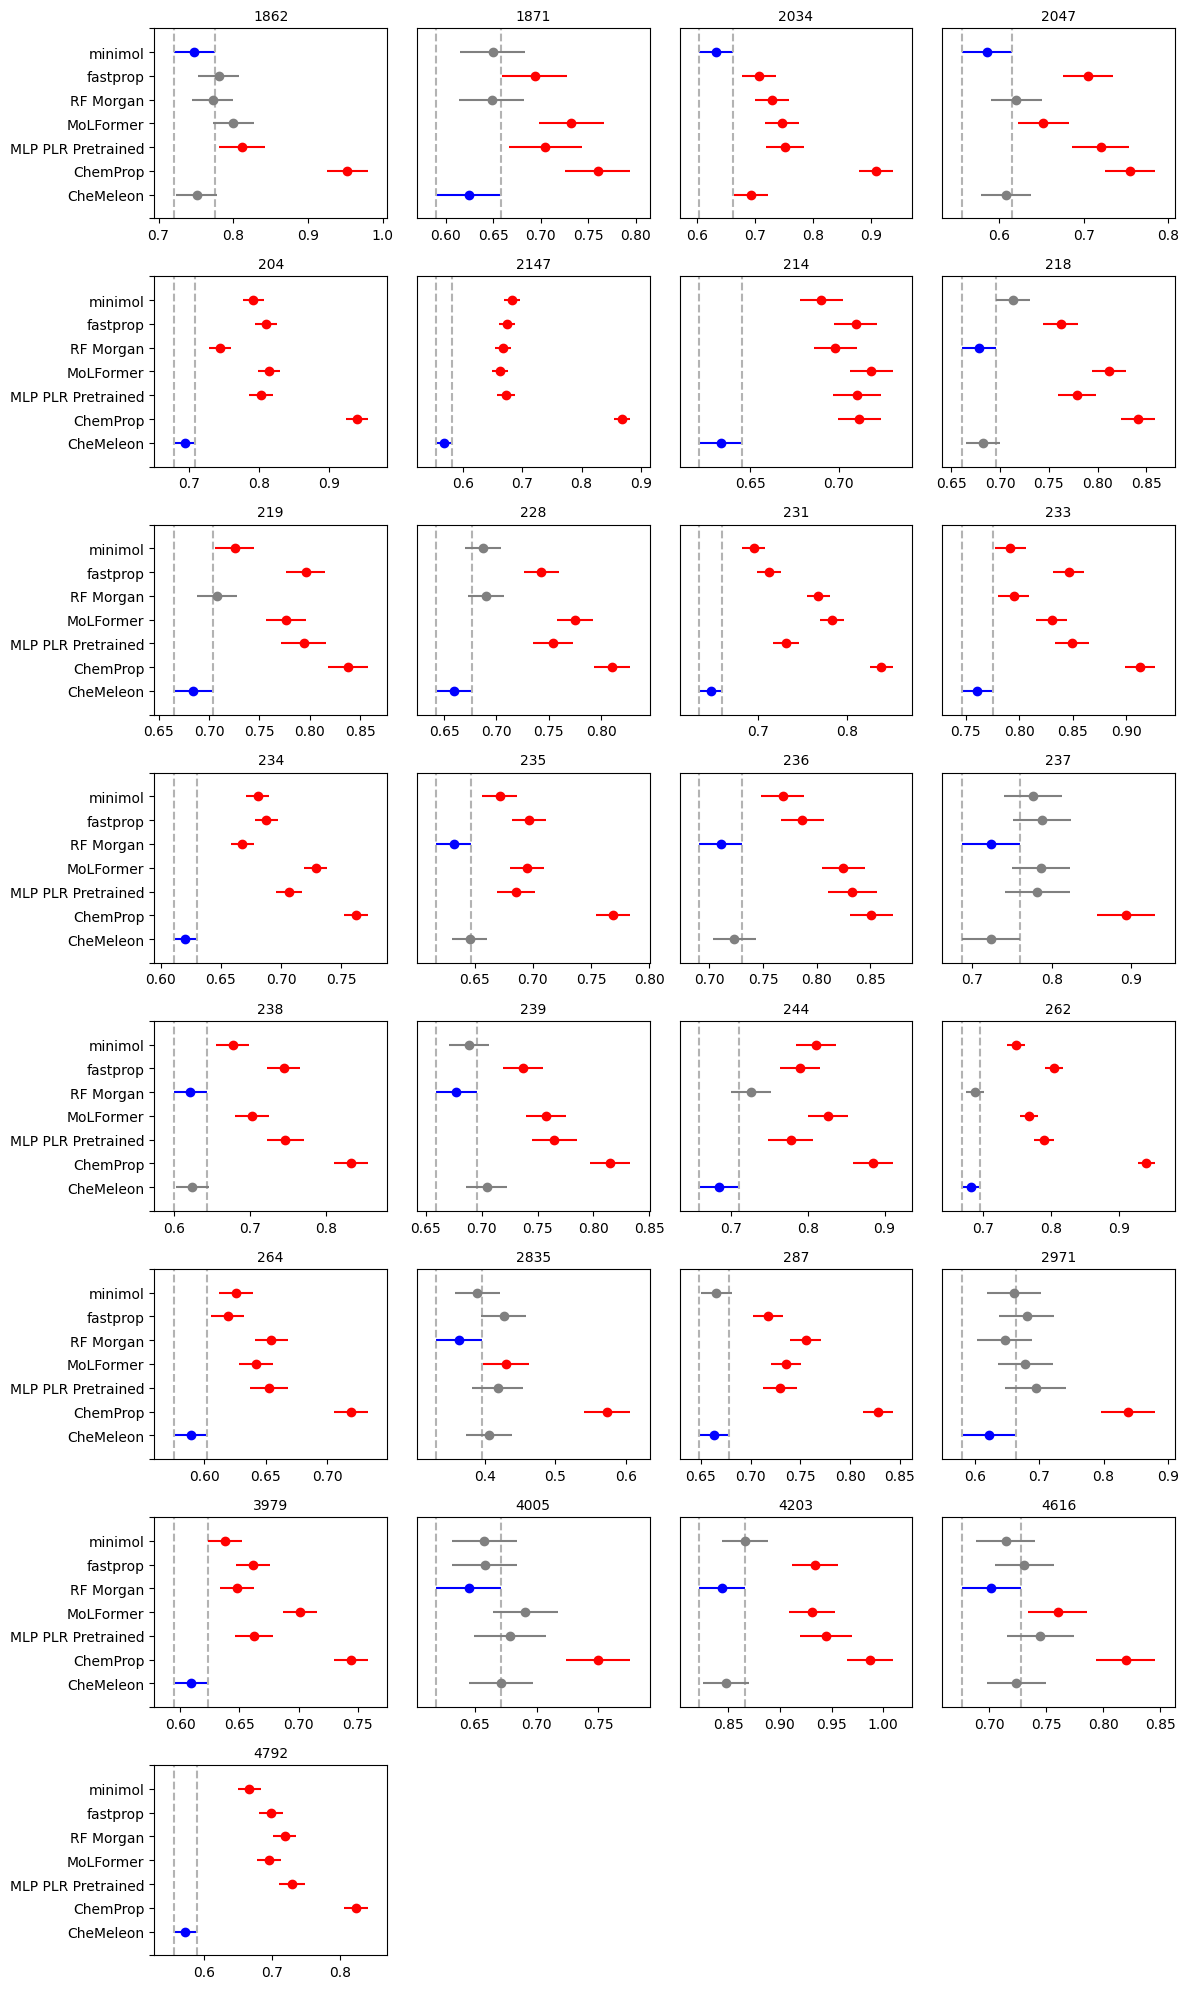

In [14]:
outdir = Path("cliffs")
outdir.mkdir(exist_ok=True)

rank_tracker = defaultdict(int)
benchmark_groups = df_2.groupby("benchmark", sort=False)
n_benchmarks = len(benchmark_groups)

ncols = 4
nrows = int(np.ceil(n_benchmarks / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
axes = axes.flatten()

max_rmse = df_2["avg"].max() * 1.10
min_rmse = df_2["avg"].min() * 0.90

for i, (benchmark, bench_df) in enumerate(benchmark_groups):
    ax = axes[i]
    
    # Run Tukey HSD
    tukey = pairwise_tukeyhsd(bench_df["avg"], bench_df["model"])
    
    # Plot Tukey HSD
    comparison_name = bench_df.groupby("model")["avg"].mean().idxmin()
    tukey.plot_simultaneous(comparison_name=comparison_name, ax=ax, figsize=(12, 20))
    ax.set_title(benchmark, fontdict=dict(fontsize=10))
    # ax.set_xlim(min_rmse, max_rmse)
    
    # plot just the individual benchmark in a separate file
    fig_indiv, ax_indiv = plt.subplots()
    tukey.plot_simultaneous(comparison_name=comparison_name, ax=ax_indiv, figsize=(6, 4))
    ax_indiv.set_title(benchmark, fontsize=12)
    ax_indiv.set_yticklabels([name.get_text().replace("_", " ") for name in ax_indiv.get_yticklabels()])
    fig_indiv.tight_layout()
    fig_indiv.savefig(outdir / f"{benchmark.replace('/', '-')}_hsd.png", dpi=300)
    plt.close(fig_indiv)  # close the figure to free memory

    # Y-axis label tweaks
    if i % ncols != 0:
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax.set_yticklabels([name.get_text().replace("_", " ") for name in ax.get_yticklabels()])
    
    # increment win counter for best group of models
    rank_tracker[comparison_name] += 1
    for model_name in bench_df["model"].unique():
        if model_name == comparison_name:
            continue
        else:
            tukey_df = pd.DataFrame(tukey.summary()[1:], columns=[str(i) for i in tukey.summary()[0]])
            tukey_df["group1"] = tukey_df["group1"].map(str)
            tukey_df["group2"] = tukey_df["group2"].map(str)
            if tukey_df[
                ((tukey_df["group1"] == comparison_name) & (tukey_df["group2"] == model_name)) | 
                ((tukey_df["group1"] == model_name) & (tukey_df["group2"] == comparison_name))
            ]["reject"].values[0].data == False:
                rank_tracker[model_name] += 1
                continue  # no need to check the rest


# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig(outdir / "combined.png", dpi=600)

results = pd.DataFrame.from_records(
    [{
        "model": model.replace("_", " "),
        "win count": win_count,
        "win rate (%)": 100 * win_count / n_benchmarks,
    } for model, win_count in rank_tracker.items()
    ]).sort_values(by="win rate (%)", axis=0, ascending=False)
results.round(1)
